This file demonstrate the solar experiment shown in section 6.3, where we compare EnbPI, SPCI, AdaptiveCI, and Nex-CP WLS

It is current written to be executed in google colaboratory.

Please place the following files in the same directory as this `.ipynb`, which are a part of this Github repository

```
  utils_quick.py

  utils_latest.py

  utils_EnbPI.py

  PI_class_EnbPI.py

  Data/Solar_Atl_data.csv
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pickle5
!pip install --upgrade --no-deps statsmodels
!pip install scikit-garden
!pip install scikit-learn==0.22.2 # Needed for scikit-garden to work properly. Restart runtime is NOT needed

In [3]:
import sys
path = '/content/drive/MyDrive/EnbPI' # You are free to replace this with where you place this file on drive
sys.path.insert(0,path)

In [4]:
%cd /content/drive/MyDrive/EnbPI

/content/drive/MyDrive/EnbPI


In [5]:
import calendar
import seaborn as sns
from statsmodels.tsa.stattools import pacf
import importlib as ipb
import pdb
import matplotlib.pyplot as plt
from scipy.sparse import random
import pandas as pd
import numpy as np
import importlib
import sys
import math
import time as time
import utils_quick as util
import utils_latest
import warnings
import torch
import torch.nn as nn
import pickle
from skgarden import RandomForestQuantileRegressor
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Required functions

In [22]:
#### Main Class ####
class prediction_interval_with_SPCI():
    '''
        Create prediction intervals assuming Y_t = f(X_t) + \sigma(X_t)\eps_t
        Currently, assume the regression function is by default MLP implemented with PyTorch, as it needs to estimate BOTH f(X_t) and \sigma(X_t), where the latter is impossible to estimate using scikit-learn modules

        Most things carry out, except that we need to have different estimators for f and \sigma.

        fit_func = None: use MLP above
    '''

    def __init__(self, X_train, X_predict, Y_train, Y_predict, fit_func=None):
        self.regressor = fit_func
        self.X_train = X_train
        self.X_predict = X_predict
        self.Y_train = Y_train
        self.Y_predict = Y_predict
        # Predicted training data centers by EnbPI
        self.Ensemble_train_interval_centers = []
        self.Ensemble_train_interval_sigma = []
        # Predicted test data centers by EnbPI
        self.Ensemble_pred_interval_centers = []
        self.Ensemble_pred_interval_sigma = []
        self.Ensemble_online_resid = []  # LOO scores
        self.beta_hat_bins = []

    def fit_bootstrap_models_online(self, B, miss_test_idx=[], fit_sigmaX=True):
        '''
          Train B bootstrap estimators from subsets of (X_train, Y_train), compute aggregated predictors, and compute the residuals
          fit_sigmaX: If False, just avoid predicting \sigma(X_t) by defaulting it to 1
        '''
        n, d = self.X_train.shape
        n1 = len(self.X_predict)
        # hold indices of training data for each f^b
        boot_samples_idx = util.generate_bootstrap_samples(n, n, B)
        # hold predictions from each f^b for fX and sigma&b for sigma
        boot_predictionsFX = torch.zeros(B, n+n1).to(device)
        boot_predictionsSigmaX = torch.ones(B, n+n1).to(device)
        # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
        in_boot_sample = np.zeros((B, n), dtype=bool)
        out_sample_predictFX = torch.zeros(n, n1).to(device)
        out_sample_predictSigmaX = torch.ones(n, n1).to(device)
        start = time.time()
        Xfull = torch.vstack([self.X_train, self.X_predict])
        for b in range(B):
            Xboot, Yboot = self.X_train[boot_samples_idx[b],
                                        :], self.Y_train[boot_samples_idx[b], ]
            in_boot_sample[b, boot_samples_idx[b]] = True
            if self.regressor.__class__.__name__ == 'NoneType':
                start1 = time.time()
                model_f = MLP(d).to(device)
                optimizer_f = torch.optim.Adam(model_f.parameters(), lr=1e-3)
                if fit_sigmaX:
                    model_sigma = MLP(d, sigma=True).to(device)
                    optimizer_sigma = torch.optim.Adam(
                        model_sigma.parameters(), lr=2e-3)
                for epoch in range(300):
                    fXhat = model_f(Xboot)
                    sigmaXhat = torch.ones(len(fXhat)).to(device)
                    if fit_sigmaX:
                        sigmaXhat = model_sigma(Xboot)
                    loss = ((Yboot-fXhat)/sigmaXhat).pow(2).mean()/2
                    optimizer_f.zero_grad()
                    if fit_sigmaX:
                        optimizer_sigma.zero_grad()
                    loss.backward()
                    optimizer_f.step()
                    if fit_sigmaX:
                        optimizer_sigma.step()
                with torch.no_grad():
                    boot_predictionsFX[b] = model_f(Xfull).flatten()
                    if fit_sigmaX:
                        boot_predictionsSigmaX[b] = model_sigma(
                            Xfull).flatten()
                print(
                    f'Took {time.time()-start1} secs to finish the {b}th boostrap model')
            else:
                model = self.regressor
                model.fit(Xboot, Yboot)
                boot_predictionsFX[b] = torch.from_numpy(
                    model.predict(Xfull).flatten()).to(device)
                # NOTE, NO sigma estimation because these methods by deFAULT are fitting Y, but we have no observation of errors
        print(
            f'Finish Fitting {B} Bootstrap models, took {time.time()-start} secs.')
        start = time.time()
        keep = []
        for i in range(n):
            b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
            pred_iFX = boot_predictionsFX[b_keep, i].mean()
            pred_iSigmaX = boot_predictionsSigmaX[b_keep, i].mean()
            pred_testFX = boot_predictionsFX[b_keep, n:].mean(0)
            pred_testSigmaX = boot_predictionsSigmaX[b_keep, n:].mean(0)
            if(len(b_keep) > 0):
                self.Ensemble_train_interval_centers.append(pred_iFX)
                self.Ensemble_train_interval_sigma.append(pred_iSigmaX)
                resid_LOO = (self.Y_train[i] - pred_iFX)/pred_iSigmaX
                out_sample_predictFX[i] = pred_testFX
                out_sample_predictSigmaX[i] = pred_testSigmaX
                keep = keep+[b_keep]
            self.Ensemble_online_resid.append(resid_LOO.item())
        sorted_out_sample_predictFX = out_sample_predictFX.mean(0)  # length n1
        sorted_out_sample_predictSigmaX = out_sample_predictSigmaX.mean(
            0)  # length n1
        resid_out_sample = (
            self.Y_predict-sorted_out_sample_predictFX)/sorted_out_sample_predictSigmaX
        if len(miss_test_idx) > 0:
            # Replace missing residuals with that from the immediate predecessor that is not missing, as
            # o/w we are not assuming prediction data are missing
            for idx in range(len(miss_test_idx)):
                i = miss_test_idx[idx]
                if i > 0:
                    j = i-1
                    while j in miss_test_idx[:idx]:
                        j -= 1
                    resid_out_sample[i] = resid_out_sample[j]

                else:
                    # The first Y during testing is missing, let it be the last of the training residuals
                    # note, training data already takes out missing values, so doing is is fine
                    resid_out_sample[0] = self.Ensemble_online_resid[-1]
        self.Ensemble_online_resid = np.append(
            self.Ensemble_online_resid, resid_out_sample.cpu().detach().numpy())
        # print(f'Finish Computing LOO residuals, took {time.time()-start} secs.')
        # print(f'Max LOO test residual is {np.max(self.Ensemble_online_resid[n:])}')
        # print(f'Min LOO test residual is {np.min(self.Ensemble_online_resid[n:])}')
        self.Ensemble_pred_interval_centers = sorted_out_sample_predictFX
        self.Ensemble_pred_interval_sigma = sorted_out_sample_predictSigmaX

    def compute_PIs_Ensemble_online(self, alpha, stride=1, smallT=True, past_window=100, use_quantile_regr=False, quantile_regr='RF'):
        '''
            smallT: if True, we would only start with the last n number of LOO residuals, rather than use the full length T ones. Used in change detection
                NOTE: smallT can be important if time-series is very dynamic, in which case training MORE data may actaully be worse (because quantile longer)
                HOWEVER, if fit quantile regression, set it to be FALSE because we want to have many training pts for the quantile regressor
            use_quantile_regr: if True, we fit conditional quantile to compute the widths, rather than simply using empirical quantile
        '''
        n1 = len(self.X_train)
        if smallT:
            n1 = min(past_window, len(self.X_train))
        # Now f^b and LOO residuals have been constructed from earlier
        out_sample_predict = self.Ensemble_pred_interval_centers.cpu().detach().numpy()
        out_sample_predictSigmaX = self.Ensemble_pred_interval_sigma
        start = time.time()
        # Matrix, where each row is a UNIQUE slice of residuals with length stride.
        resid_strided = util.strided_app(
            self.Ensemble_online_resid[len(self.X_train)-n1:-1], n1, stride)
        print(f'Shape of slided residual lists is {resid_strided.shape}')
        num_unique_resid = resid_strided.shape[0]
        width_left = np.zeros(num_unique_resid)
        width_right = np.zeros(num_unique_resid)
        # # NEW, alpha becomes alpha_t. Uncomment things below if we decide to use this upgraded EnbPI
        # alpha_t = alpha
        # errs = []
        # gamma = 0.005
        # method = 'simple'  # 'simple' or 'complex'
        # self.alphas = []
        # NOTE: 'max_features='log2', max_depth=2' make the model "simpler", which improves performance in practice
        for i in range(num_unique_resid):
            # for p in range(stride):  # NEW for adaptive alpha
            past_resid = resid_strided[i, :]
            curr_SigmaX = out_sample_predictSigmaX[i].item()
            if use_quantile_regr:
                # New predicted conditional quntile
                # 1. Get "past_resid" into an auto-regressive fashion
                # This should be more carefully examined, b/c it depends on how long \hat{\eps}_t depends on the past
                # From practice, making it small make intervals wider
                n2 = past_window
                residX = sliding_window_view(past_resid, window_shape=n2)
                residY = past_resid[n2:]
                # 2. Fit the model. Default quantile regressor is the quantile RF from
                # scikit-garden: https://scikit-garden.github.io/
                # NOTE, should NOT warm start, as it makes result poor, although training is longer
                if quantile_regr == 'RF':
                    rfqr = RandomForestQuantileRegressor(
                        max_depth=2, random_state=0)
                    rfqr.fit(residX[:-1], residY)
                    # 3. Find best \hat{\beta} via evaluating many quantiles
                    beta_hat_bin = util.binning_use_RF_quantile_regr(
                        rfqr, residX[-1], alpha)
                    width_left[i] = curr_SigmaX*rfqr.predict(
                        residX[-1].reshape(1, -1), math.ceil(100 * beta_hat_bin))
                    width_right[i] = curr_SigmaX*rfqr.predict(
                        residX[-1].reshape(1, -1), math.ceil(100 * (1-alpha+beta_hat_bin)))
                # if quantile_regr == 'LR':
                #     start1 = time.time()
                #     wleft, wright = util.binning_use_linear_quantile_regr(
                #         residX, residY, alpha)
                #     if i == 0:
                #         print(
                #             f'100 Linear QRegr approx. takes {100*(time.time()-start1)} secs.')
                #     width_left[i] = curr_SigmaX*wleft
                #     width_right[i] = curr_SigmaX*wright
                if i % int(num_unique_resid/20) == 0:
                    print(
                        f'Width at test {i} is {width_right[i]-width_left[i]}')
            else:
                # Naive empirical quantile
                # The number of bins will be determined INSIDE binning
                beta_hat_bin = util.binning(past_resid, alpha)
                # beta_hat_bin = util.binning(past_resid, alpha_t)
                self.beta_hat_bins.append(beta_hat_bin)
                width_left[i] = curr_SigmaX*np.percentile(
                    past_resid, math.ceil(100*beta_hat_bin))
                width_right[i] = curr_SigmaX*np.percentile(
                    past_resid, math.ceil(100*(1-alpha+beta_hat_bin)))
        print(
            f'Finish Computing {num_unique_resid} UNIQUE Prediction Intervals, took {time.time()-start} secs.')
        # This is because |width|=T1/stride.
        width_left = np.repeat(width_left, stride)
        # This is because |width|=T1/stride.
        width_right = np.repeat(width_right, stride)
        PIs_Ensemble = pd.DataFrame(np.c_[out_sample_predict+width_left,
                                          out_sample_predict+width_right], columns=['lower', 'upper'])
        self.PIs_Ensemble = PIs_Ensemble

    '''
        All together
    '''

    def get_results(self, alpha, data_name, itrial, true_Y_predict=[], method='Ensemble'):
        '''
            NOTE: I added a "true_Y_predict" option, which will be used for calibrating coverage under missing data
            In particular, this is needed when the Y_predict we use for training is NOT the same as true Y_predict
        '''
        results = pd.DataFrame(columns=['itrial', 'dataname', 'muh_fun',
                                        'method', 'train_size', 'coverage', 'width'])
        train_size = len(self.X_train)
        if method == 'Ensemble':
            PI = self.PIs_Ensemble
        Ytest = self.Y_predict.cpu().detach().numpy()
        coverage = ((np.array(PI['lower']) <= Ytest) & (
            np.array(PI['upper']) >= Ytest)).mean()
        if len(true_Y_predict) > 0:
            coverage = ((np.array(PI['lower']) <= true_Y_predict) & (
                np.array(PI['upper']) >= true_Y_predict)).mean()
        print(f'Average Coverage is {coverage}')
        width = (PI['upper'] - PI['lower']).mean()
        print(f'Average Width is {width}')
        results.loc[len(results)] = [itrial, data_name,
                                     'torch_MLP', method, train_size, coverage, width]
        return results


def CP_LS(X, Y, x, alpha, weights=[], tags=[]):
    # Barber et al. 2022: Nex-CP
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)

    if(len(tags) == 0):
        tags = np.ones(n+1)

    if(len(weights) == 0):
        weights = np.ones(n+1)
    if(len(weights) == n):
        weights = np.r_[weights, 1]
    weights = weights / np.sum(weights)

    # randomly permute one weight for the regression
    random_ind = int(np.where(np.random.multinomial(1, weights, 1))[1])
    tags[np.c_[random_ind, n]] = tags[np.c_[n, random_ind]]

    XtX = (X.T*tags[:-1]).dot(X) + np.outer(x, x)*tags[-1]
    a = Y - X.dot(np.linalg.solve(XtX, (X.T*tags[:-1]).dot(Y)))
    b = -X.dot(np.linalg.solve(XtX, x))*tags[-1]
    a1 = -x.T.dot(np.linalg.solve(XtX, (X.T*tags[:-1]).dot(Y)))
    b1 = 1 - x.T.dot(np.linalg.solve(XtX, x))*tags[-1]
    # if we run weighted least squares on (X[1,],Y[1]),...(X[n,],Y[n]),(x,y)
    # then a + b*y = residuals of data points 1,..,n
    # and a1 + b1*y = residual of data point n+1

    y_knots = np.sort(
        np.unique(np.r_[((a-a1)/(b1-b))[b1-b != 0], ((-a-a1)/(b1+b))[b1+b != 0]]))
    y_inds_keep = np.where(((np.abs(np.outer(a1+b1*y_knots, np.ones(n)))
                             > np.abs(np.outer(np.ones(len(y_knots)), a)+np.outer(y_knots, b))) *
                            weights[:-1]).sum(1) <= 1-alpha)[0]
    y_PI = np.array([y_knots[y_inds_keep.min()], y_knots[y_inds_keep.max()]])
    if(weights[:-1].sum() <= 1-alpha):
        y_PI = np.array([-np.inf, np.inf])
    return y_PI

#### Model and data helper ####


class MLP(nn.Module):
    def __init__(self, d, sigma=False):
        super(MLP, self).__init__()
        H = 64
        layers = [nn.Linear(d, H), nn.ReLU(), nn.Linear(
            H, H), nn.ReLU(), nn.Linear(H, 1)]
        self.sigma = sigma
        if self.sigma:
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        perturb = 1e-3 if self.sigma else 0
        return self.layers(x)+perturb


def get_new_data():
    ''' Note, the difference from earlier case 3 in paper is that
        1) I reduce d from 100 to 20,
        2) I let X to be different, so sigmaX differs
            The sigmaX is a linear model so this effect in X is immediate
        I keep the same AR(1) eps & everything else.'''
    def True_mod_nonlinear_pre(feature):
        '''
        Input:
        Output:
        Description:
            f(feature): R^d -> R
        '''
        # Attempt 3 Nonlinear model:
        # f(X)=sqrt(1+(beta^TX)+(beta^TX)^2+(beta^TX)^3), where 1 is added in case beta^TX is zero
        d = len(feature)
        np.random.seed(0)
        # e.g. 20% of the entries are NON-missing
        beta1 = random(1, d, density=0.2).A
        betaX = np.abs(beta1.dot(feature))
        return (betaX + betaX**2 + betaX**3)**(1/4)
    Tot, d = 2000, 20
    Fmap = True_mod_nonlinear_pre
    # Multiply each random feature by exponential component, which is repeated every Tot/rep elements
    rep = 10
    mult = np.exp(np.repeat(np.linspace(0, 2, rep), Tot/rep)).reshape(Tot, 1)
    X = np.random.rand(Tot, d)*mult
    fX = np.array([Fmap(x) for x in X]).flatten()
    beta_Sigma = 0.1*np.ones(d)
    sigmaX = np.maximum(X.dot(beta_Sigma).T, 0)
    with open(f'Data_nochangepts_nonlinear.p', 'rb') as fp:
        Data_dc = pickle.load(fp)
    eps = Data_dc['Eps']
    Y = fX + sigmaX*eps
    np.random.seed(1103)
    idx = np.random.choice(Tot, Tot, replace=False)
    Y, X, fX, sigmaX, eps = Y[idx], X[idx], fX[idx], sigmaX[idx], eps[idx]
    return {'Y': torch.from_numpy(Y).float(), 'X': torch.from_numpy(X).float(), 'f(X)': fX, 'sigma(X)': sigmaX, 'Eps': eps}


def get_new_data_simple(num_pts, alpha, beta):
    '''
        Y_t = alpha*Y_{t-1}+\eps_t
        \eps_t = beta*\eps_{t-1}+v_t
        v_t ~ N(0,1)
        So X_t = Y_{t-1}, f(X_t) = alpha*X_t
        If t = 0:
            X_t = 0, Y_t=\eps_t = v_t
    '''
    v0 = torch.randn(1)
    Y, X, fX, eps = [v0], [torch.zeros(1)], [torch.zeros(1)], [v0]
    scale = torch.sqrt(torch.ones(1)*0.1)
    for _ in range(num_pts-1):
        vt = torch.randn(1)*scale
        X.append(Y[-1])
        fX.append(alpha*Y[-1])
        eps.append(beta*eps[-1]+vt)
        Y.append(fX[-1]+eps[-1])
    Y, X, fX, eps = torch.hstack(Y), torch.vstack(
        X), torch.vstack(fX), torch.hstack(eps)
    return {'Y': Y.float(), 'X': X.float(), 'f(X)': fX, 'Eps': eps}


def electric_dataset():
    # ELEC2 data set
    # downloaded from https://www.kaggle.com/yashsharan/the-elec2-dataset
    data = pd.read_csv('electricity-normalized.csv')
    col_names = data.columns
    data = data.to_numpy()

    # remove the first stretch of time where 'transfer' does not vary
    data = data[17760:]

    # set up variables for the task (predicting 'transfer')
    covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
    response_col = 'transfer'
    # keep data points for 9:00am - 12:00pm
    keep_rows = np.where((data[:, 2] > data[17, 2])
                         & (data[:, 2] < data[24, 2]))[0]

    X = data[keep_rows][:, np.where(
        [t in covariate_col for t in col_names])[0]]
    Y = data[keep_rows][:, np.where(col_names == response_col)[0]].flatten()
    X = X.astype('float64')
    Y = Y.astype('float64')

    return X, Y

#### Other helpers ####

def rolling_avg(x, window=100):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]


def dict_to_latex(dict):
    DF = pd.DataFrame.from_dict(np.vstack(dict.values()))
    keys = list(dict.keys())
    index = np.array([[f'{key} coverage', f'{key} width']
                     for key in keys]).flatten()
    DF.index = index
    DF.columns = train_ls
    print(DF)
    print(DF.round(2).to_latex())

# Running tests

In [7]:
alpha = 0.1
# Whether we save dictionary for plotting rolling cov or width
save_dict_rolling = True
non_stat_solar = True  # Whether X_t in solar contains time covariate
if non_stat_solar == False:
    # We only visualize rolling results under non-stationary feature X_t
    save_dict_rolling = False
train_ls = [0.5, 0.6, 0.7, 0.8]
train_ls = [0.8]

## EnbPI & SPCI

In [ ]:
'''
    Arguments:
        simulation: bool. True use simulated data. False use solar
            simul_type: int. 1 = simple state-space. 2 = non-statioanry. 3 = heteroskedastic
            The latter 2 follows from case 3 in paper
        conditions: Contain these three below:
            use_quantile_regr: bool. True use `quantile_regr`. False use empirical quatile
            quantile_regr: str. Which quantile regression to fit residuals (e.g., "RF", "LR")
            fit_func: None or sklearn module with methods `.fit` & `.predict`. If None, use MLP above

        fit_sigmaX: bool. True if to fit heteroskedastic errors. ONLY activated if fit_func is NONE (i.e. MLP), because errors are unobserved so `.fit()` does not work

        smallT: bool. True if empirical quantile uses not ALL T residual in the past to get quantile (should be tuned as sometimes longer memory causes poor coverage)
            past_window: int. If smallT True, EnbPI uses `past_window` most residuals to get width. FOR quantile_regr of residuals, it determines the dimension of the "feature" that predict new quantile of residuals autoregressively

    Results:
        dict: contains dictionary of coverage and width under different training fraction (fix alpha) under various argument combinations

'''
importlib.reload(sys.modules['utils_quick'])
importlib.reload(sys.modules['utils_latest'])
dict_full = {}
dict_rolling = {}
''' Test '''
# Conditions: [if simulation, if use quantile regr, which quantile regr]
conditions_simulation = [[True, False, ''], [True, True, 'RF']]
conditions_real = [[False, False, ''], [False, True, 'RF']]
# For burn-in period plot
PIs_EnbPI = 0
PIs_SPCI = 0
for condition in conditions_real:
    simulation, use_quantile_regr, quantile_regr = condition
    name = 'SPCI' if use_quantile_regr else 'EnbPI'
    result_cov, result_width = [], []
    for train_frac in train_ls:
        print('########################################')
        print(f'Train frac at {train_frac}')
        if simulation:
            simul_type = 2  # 1, 2, 3
            fit_sigmaX = True if simul_type == 3 else False  # If we fit variance given X_t
            if simul_type == 1:
                Data_dict = get_new_data_simple(
                    num_pts=2000, alpha=0.9, beta=0.9)
                data_name = 'simulation_state_space'
            if simul_type == 2:
                data_container = utils_latest.data_loader()
                _, Data_dict = data_container.get_non_stationary_simulate()
                Data_dict['X'] = torch.from_numpy(Data_dict['X']).float()
                Data_dict['Y'] = torch.from_numpy(Data_dict['Y']).float()
                data_name = 'simulate_nonstationary'
            if simul_type == 3:
                # NOTE: somehow for this case, currently RF quantile regression does not yield shorter interval. We may tune past window to get different results (like decrease it to 250) if need
                Data_dict = get_new_data()
                data_name = 'simulate_heteroskedastic'
            X_full, Y_full = Data_dict['X'].to(
                device), Data_dict['Y'].to(device)
            B = 20
            past_window = 500
            fit_func = None  # It is MLP above
        else:
            data_name = 'solar'  # 'electric' or 'solar'
            if data_name == 'solar':
                # Get solar data WITH time t as covariate
                dloader = utils_latest.data_loader()
                Y_full, X_full_old, X_full_nonstat = dloader.get_non_stationary_real(
                    univariate=False)
                if non_stat_solar:
                    X_full = X_full_nonstat
                else:
                    X_full = X_full_old
                fit_func = RandomForestRegressor(n_estimators=10, criterion='mse',
                                                  bootstrap=False, n_jobs=-1)
                past_window = 500
            if data_name == 'electric':
                X_full, Y_full = electric_dataset()
                fit_func = RandomForestRegressor(n_estimators=10, max_depth=1, criterion='mse',
                                                  bootstrap=False, n_jobs=-1)
                past_window = 300
            Y_full, X_full = torch.from_numpy(Y_full).float().to(
                device), torch.from_numpy(X_full).float().to(device)
            fit_sigmaX = False
            B = 25
        alpha, itrial = 0.1, 0
        N = int(X_full.shape[0]*train_frac)
        X_train, X_predict, Y_train, Y_predict = X_full[:
                                                        N], X_full[N:], Y_full[:N], Y_full[N:]

        # Train
        EnbPI = prediction_interval_with_SPCI(
            X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
        EnbPI.fit_bootstrap_models_online(B, fit_sigmaX=fit_sigmaX)
        # Under cond quantile, we are ALREADY using the last window for prediction so smallT is True
        smallT = not use_quantile_regr
        EnbPI.compute_PIs_Ensemble_online(
            alpha, smallT=smallT, past_window=past_window, use_quantile_regr=use_quantile_regr,
            quantile_regr=quantile_regr)
        results = EnbPI.get_results(alpha, data_name, itrial)
        result_cov.append(results['coverage'].item())
        result_width.append(results['width'].item())
        # Lastly, compute rolling width to plot
        PI = EnbPI.PIs_Ensemble
        if use_quantile_regr:
            PIs_SPCI = PI
        else:
            PIs_EnbPI = PI
        Ytest = EnbPI.Y_predict.cpu().detach().numpy()
        coverage = ((np.array(PI['lower']) <= Ytest)
                    & (np.array(PI['upper']) >= Ytest))
        width = ((np.array(PI['upper'])-np.array(PI['lower'])))
        # cov_moving = rolling_avg(coverage)
        # width_moving = rolling_avg(width)
        dict_rolling[f'{name}{np.round(train_frac,2)}'] = np.vstack([
            coverage, width])
        if save_dict_rolling:
            with open(f'EnbPI_rolling_{data_name}.p', 'wb') as fp:
                pickle.dump(dict_rolling, fp,
                            protocol=pickle.HIGHEST_PROTOCOL)
        if simulation:
            # # Examine recovery of F and Sigma
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            ax[0, 0].plot(Data_dict['f(X)'])
            ax[0, 1].plot(
                EnbPI.Ensemble_pred_interval_centers.cpu().detach().numpy())
            ax[1, 0].plot(Data_dict['Eps'])
            ax[1, 1].plot(EnbPI.Ensemble_online_resid)
            titles = [r'True $f(X)$', r'Est $f(X)$',
                      r'True $\epsilon$', r'Est $\epsilon$']
            fig.tight_layout()
            for i, ax_i in enumerate(ax.flatten()):
                ax_i.set_title(titles[i])
            fig.tight_layout()
            plt.show()
            plt.close()
    dict_full[name] = np.vstack([result_cov, result_width])

Due to variability, what you see for EnbPI may be different. However, in general EnbPI intervals are wider

0.8 indicates that training fraction as a percentage of total data is 80\% or 1600 observations

In [9]:
dict_to_latex(dict_full)

                      0.8
EnbPI coverage   0.877500
EnbPI width     49.640250
SPCI coverage    0.917500
SPCI width      47.726013
\begin{tabular}{lr}
\toprule
{} &    0.8 \\
\midrule
EnbPI coverage &   0.88 \\
EnbPI width    &  49.64 \\
SPCI coverage  &   0.92 \\
SPCI width     &  47.73 \\
\bottomrule
\end{tabular}



## AdaptiveCI

In [ ]:
import PI_class_EnbPI
!pip install skranger
# Need for skranger to work properly. Sorry for the possibly avoidable complexity. We assumed one can 
# get away with this if skranger or scikit-garden is consistently used
# May need to restart runtime
!pip install scikit-learn==0.24
from skranger.ensemble import RangerForestRegressor

In [ ]:
# NOTE: the variance of this method seems high, and I often need to tune a LOT to avoid yielding very very high coverage.
data_name = 'solar'
dict_AdaptiveCI = {}
dict_rolling_AdaptiveCI = {}
cov_ls, width_ls = [], []
for train_frac in train_ls:
    # As it is split conformal, the result can be random, so we repeat over seed
    seeds = [524, 1103, 1111, 1214, 1228]
    cov_tmp_ls, width_tmp_ls = [], []
    print('########################################')
    print(f'Train frac at {train_frac} over {len(seeds)} seeds')
    for seed in seeds:
        dloader = utils_latest.data_loader()
        Y_full, X_full_old, X_full_nonstat = dloader.get_non_stationary_real(
            univariate=False)
        if non_stat_solar:
            X_full = X_full_nonstat
        else:
            X_full = X_full_old
        N = int(X_full.shape[0]*train_frac)
        X_train, X_predict, Y_train, Y_predict = X_full[:
                                                        N], X_full[N:], Y_full[:N], Y_full[N:]
        if non_stat_solar:
            # More complex yields wider intervals and more conservative coverage
            fit_func = RangerForestRegressor(
                n_estimators=5, quantiles=True, seed=seed)
        else:
            fit_func = RangerForestRegressor(
                n_estimators=10, quantiles=True, seed=seed)
        PI_test_adaptive = PI_class_EnbPI.QOOB_or_adaptive_CI(
            fit_func, X_train, X_predict, Y_train, Y_predict)
        AdaptiveCI_result = PI_test_adaptive.compute_AdaptiveCI_intervals(
            data_name, 0, l=int(0.75 * X_train.shape[0]),
            alpha=alpha)
        PIs_AdaptiveCI = PI_test_adaptive.PIs
        Ytest = PI_test_adaptive.Y_predict
        coverage = ((np.array(PIs_AdaptiveCI['lower']) <= Ytest)
                    & (np.array(PIs_AdaptiveCI['upper']) >= Ytest))
        width = (
            (np.array(PIs_AdaptiveCI['upper'])-np.array(PIs_AdaptiveCI['lower'])))
        cov_tmp_ls.append(coverage)
        width_tmp_ls.append(width)
    coverage = np.vstack(cov_tmp_ls).mean(axis=0)
    width = np.vstack(width_tmp_ls).mean(axis=0)
    PIs_AdaptiveCI = width  # for plot later
    # cov_moving = rolling_avg(coverage)
    # width_moving = rolling_avg(width)
    dict_rolling_AdaptiveCI[f'placeholder{np.round(train_frac,2)}'] = np.vstack([
        coverage, width])
    if save_dict_rolling:
        with open(f'AdaptiveCI_rolling_{data_name}.p', 'wb') as fp:
            pickle.dump(dict_rolling_AdaptiveCI, fp,
                        protocol=pickle.HIGHEST_PROTOCOL)
    cov_ls.append(np.mean(coverage))
    width_ls.append(np.mean(width))
dict_AdaptiveCI['AdaptiveCI'] = np.vstack([cov_ls, width_ls])

In [12]:
dict_to_latex(dict_AdaptiveCI)

                           0.8
AdaptiveCI coverage   0.903500
AdaptiveCI width     60.542017
\begin{tabular}{lr}
\toprule
{} &    0.8 \\
\midrule
AdaptiveCI coverage &   0.90 \\
AdaptiveCI width    &  60.54 \\
\bottomrule
\end{tabular}



## Nex-CP WLS

In [ ]:
cov, width = [], []
dict_full = {}
dict_rolling = {}
data_name = 'solar'  # Eletric or solar
if data_name == 'solar':
    # Get solar data WITH time t as covariate
    dloader = utils_latest.data_loader()
    Y_full, X_full_old, X_full_nonstat = dloader.get_non_stationary_real(
        univariate=False)
    if non_stat_solar:
        X_full = X_full_nonstat
    else:
        X_full = X_full_old
if data_name == 'electric':
    X_full, Y_full = electric_dataset()
N = len(X_full)
for train_frac in train_ls:
    train_size = int(train_frac*N)
    PI_nexCP_WLS = np.zeros((N, 2))
    for n in np.arange(train_size, N):
        # weights and tags (parameters for new methods)
        rho = 0.99
        rho_LS = 0.99
        weights = rho**(np.arange(n, 0, -1))
        tags = rho_LS**(np.arange(n, -1, -1))
        PI_nexCP_WLS[n, :] = CP_LS(X_full[:n, :], Y_full[:n], X_full[n, :], alpha,
                                    weights=weights, tags=tags)
        inc = int((N-train_size)/20)
        if (n-train_size) % inc == 0:
            print(
                f'NEX-CP WLS width at {n-train_size} is: {PI_nexCP_WLS[n,1] - PI_nexCP_WLS[n,0]}')
    cov_nexCP_WLS = (PI_nexCP_WLS[train_size:, 0] <= Y_full[train_size:N]) *\
        (PI_nexCP_WLS[train_size:, 1] >= Y_full[train_size:N])
    PI_width_nexCP_WLS = PI_nexCP_WLS[train_size:,
                                      1]-PI_nexCP_WLS[train_size:, 0]
    cov.append(np.mean(cov_nexCP_WLS))
    width.append(np.mean(PI_width_nexCP_WLS))
    print(
        f'At {train_frac} tot data \n cov: {cov[-1]} & width: {width[-1]}')
    # Rolling coverage and width
    # cov_moving = rolling_avg(cov_nexCP_WLS)
    # width_moving = rolling_avg(PI_width_nexCP_WLS)
    dict_rolling[f'placeholder{train_frac}'] = np.vstack(
        [cov_nexCP_WLS, PI_width_nexCP_WLS])
    if save_dict_rolling:
        with open(f'NEXCP_rolling_{data_name}.p', 'wb') as fp:
            pickle.dump(dict_rolling, fp, protocol=pickle.HIGHEST_PROTOCOL)
dict_full = {'Nex-CP WLS': np.vstack([cov, width])}

In [15]:
dict_to_latex(dict_full)

                            0.8
Nex-CP WLS coverage    0.897500
Nex-CP WLS width     103.824461
\begin{tabular}{lr}
\toprule
{} &     0.8 \\
\midrule
Nex-CP WLS coverage &    0.90 \\
Nex-CP WLS width    &  103.82 \\
\bottomrule
\end{tabular}



# Visualization

## Burn-in plot

In [43]:
import pickle5 as pickle

In [51]:
with open(f'EnbPI_rolling_{data_name}.p', 'rb') as fp:
    dict_rolling = pickle.load(fp)
with open(f'NEXCP_rolling_{data_name}.p', 'rb') as fp:
    NEXCP_dict_rolling = pickle.load(fp)
with open(f'AdaptiveCI_rolling_{data_name}.p', 'rb') as fp:
    AdaptiveCI_dict_rolling = pickle.load(fp)
vanilla_cov_rolling, vanilla_width_rolling = dict_rolling['EnbPI0.8']
predictive_cov_rolling, predictive_width_rolling = dict_rolling['SPCI0.8']
NEXCP_cov_rolling, NEXCP_width_rolling = NEXCP_dict_rolling['placeholder0.8']
AdaptiveCI_cov_rolling, AdaptiveCI_width_rolling = AdaptiveCI_dict_rolling[
    'placeholder0.8']

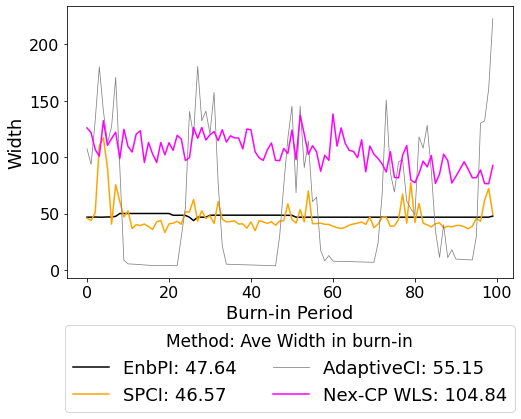

In [52]:
window_size = 100
fig, ax = plt.subplots(figsize=(8, 5))
first = vanilla_width_rolling[:window_size]
ax.plot(first, label=f'EnbPI: {np.round(first.mean(),2)}', color='black')
second = predictive_width_rolling[:window_size]
ax.plot(second, label=f'SPCI: {np.round(second.mean(),2)}', color='orange')
third = AdaptiveCI_width_rolling[:window_size]
ax.plot(
    third, label=f'AdaptiveCI: {np.round(third.mean(),2)}', color='gray', linewidth=0.75)
fourth = NEXCP_width_rolling[:window_size]
ax.plot(
    fourth, label=f'Nex-CP WLS: {np.round(fourth.mean(),2)}', color='magenta')
ax.set_xlabel('Burn-in Period')
ax.set_ylabel('Width')
ax.legend(title='Method: Ave Width in burn-in', title_fontsize=17,
          loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.525))
suffix = 'non_stat_' if non_stat_solar else ''
plt.savefig(f'Brun_in_plot_{suffix}{data_name}.pdf', dpi=300,
            bbox_inches='tight',
            pad_inches=0)

## Rolling cov and width after burn-in

EnbPI vs. NEXCP+AdaptiveCI on solar
(8760, 8)


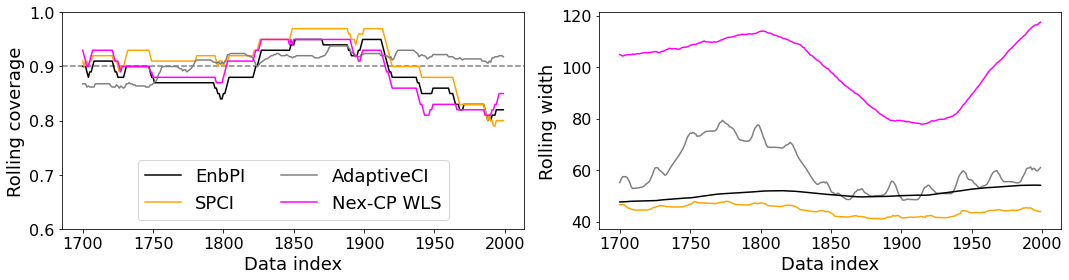

In [53]:
dsets = ['solar']
methods = ['NEXCP+AdaptiveCI']
for data_name in dsets:
    for compete in methods:
        if data_name == 'electric' and compete == 'AdaptiveCI':
            continue
        print(f'EnbPI vs. {compete} on {data_name}')
        if data_name == 'solar':
            # Get solar data WITH time t as covariate
            dloader = utils_latest.data_loader()
            Y_full, X_full_old, X_full_nonstat = dloader.get_non_stationary_real(
                univariate=False)
            if non_stat_solar:
                X_full = X_full_nonstat
            else:
                X_full = X_full_old
        vanilla_cov_rolling, vanilla_width_rolling = rolling_avg(
            vanilla_cov_rolling, window_size), rolling_avg(vanilla_width_rolling, window_size)
        predictive_cov_rolling, predictive_width_rolling = rolling_avg(
            predictive_cov_rolling, window_size), rolling_avg(predictive_width_rolling, window_size)
        NEXCP_cov_rolling, NEXCP_width_rolling = rolling_avg(
            NEXCP_cov_rolling, window_size), rolling_avg(NEXCP_width_rolling, window_size)
        AdaptiveCI_cov_rolling, AdaptiveCI_width_rolling = rolling_avg(
            AdaptiveCI_cov_rolling, window_size), rolling_avg(AdaptiveCI_width_rolling, window_size)
        N = len(Y_full)
        N0 = int(0.8*len(X_full))
        fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
        ax[0].axhline(y=1-alpha, linestyle='--', color='gray')
        xaxis = np.arange(N0+window_size, N)
        ax[0].plot(xaxis, vanilla_cov_rolling,
                    color='black', label='EnbPI')
        color_tmp = 'orange'
        ax[0].plot(xaxis, predictive_cov_rolling,
                    color=color_tmp, label='SPCI')
        ax[0].plot(xaxis, AdaptiveCI_cov_rolling,
                    color='gray', label='AdaptiveCI')
        ax[0].plot(xaxis, NEXCP_cov_rolling,
                    color='magenta', label='Nex-CP WLS')
        ax[0].set_xlabel('Data index')
        ax[1].plot(xaxis, AdaptiveCI_width_rolling, color='gray')
        ax[1].plot(xaxis, NEXCP_width_rolling, color='magenta')
        ax[0].set_ylim([1-4*alpha, 1])
        ax[0].set_ylabel('Rolling coverage')
        ax[0].legend(ncol=2, loc='lower center')
        ax[1].plot(xaxis, vanilla_width_rolling, color='black')
        ax[1].plot(xaxis, predictive_width_rolling, color=color_tmp)
        ax[1].set_ylabel('Rolling width')
        ax[1].set_xlabel('Data index')
        fig.tight_layout()
        plt.savefig(f'Rolling_comparison_{compete}_{data_name}.pdf', dpi=300,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.show()
        plt.close()